# Visualizing Data

I am assuming:

- We want to fix a year (the most recent possible)
- We want to look at the whole world
- We want a scatter plot with MMR on y-axis and LE on x-axis and annotated countries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

# Load Data

In [2]:
continents = pd.read_csv("data/continents_owid.csv")

In [3]:
owid_countries = set(continents["Entity"])

In [4]:
who_pop = pd.read_excel(
    io="data/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx",
    sheet_name="Estimates",
    skiprows=16,
    usecols=[
    "Region, subregion, country or area *",
    "Year",
    "Female Life Expectancy at Birth (years)",
    "Births (thousands)"]
)
# We want absolute births
who_pop["Births (thousands)"] *= 1000

# For ease of use
who_pop.rename(
    columns={
        "Region, subregion, country or area *": "Region",
        "Female Life Expectancy at Birth (years)": "FemLifeExp",
        "Births (thousands)": "Births"},
    inplace=True
)

In [5]:
non_countries = [
    "WORLD", 
    'Sustainable Development Goal (SDG) regions',
    'Sub-Saharan Africa', 'Northern Africa and Western Asia',
       'Central and Southern Asia', 'Eastern and South-Eastern Asia',
       'Latin America and the Caribbean',
       'Oceania (excluding Australia and New Zealand)',
       'Australia/New Zealand', 'Europe and Northern America',
       'UN development groups', 'More developed regions',
       'Less developed regions', 'Least developed countries',
       'Less developed regions, excluding least developed countries',
       'Less developed regions, excluding China',
       'Land-locked Developing Countries (LLDC)',
       'Small Island Developing States (SIDS)',
       'World Bank income groups', 'High-income countries',
       'Middle-income countries', 'Upper-middle-income countries',
       'Lower-middle-income countries', 'Low-income countries',
       'No income group available', 'Geographic regions', 'AFRICA',
        'Eastern Africa', 'Middle Africa', 'Northern Africa',
        'Southern Africa', 'Western Africa', 'ASIA', 'Central Asia',
    'Eastern Asia', 'Southern Asia', 'South-Eastern Asia',
    'Western Asia', 'EUROPE', 'Eastern Europe', 'Northern Europe',
    'Southern Europe', 'Western Europe', 'LATIN AMERICA AND THE CARIBBEAN', 'Caribbean',
    'OCEANIA', 'Central America', 'South America', 'NORTHERN AMERICA']

In [6]:
# Remove regions that are not countries
who_pop = who_pop[~who_pop["Region"].isin(non_countries)]

Notice that the countries in the mortality data are the bottle neck, since this is where we grab all of our data.

In [7]:
mortality = pd.read_csv(
    "data/WHOMortalityDatabase_Map_Maternal conditions_28th March 2024 17_52.csv", skiprows=6, index_col=False
)
# We only want to keep South American countries, for the years quote in the Google Form
# For all age groups and for female
mortality = mortality.query(
    "Sex == 'Female' & `Age Group` == '[All]'"
)
# Keep only relevant columns
mortality = mortality[
    ["Country Name", "Year", "Number"]]
# Remove index, useless in this case
mortality.reset_index(drop=True, inplace=True)
# Rename venezuela
# mortality.loc[mortality["Country Name"] == "Venezuela (Bolivarian Republic of)", "Country Name"] = "Venezuela"

# Figuring Out Countries

In [8]:
# First, I want to see how many countries are in common between the WHO population prospect and the
# WHO mortality database

In [9]:
# Countries from mortality data
mort_countries = set(mortality["Country Name"].values)

In [10]:
# Countries from WHO population data
who_countries = set(who_pop["Region"].values)

In [11]:
len(mort_countries), len(who_countries)

(119, 240)

In [12]:
# Intersection
inter_countries = mort_countries.intersection(who_countries)

In [13]:
len(inter_countries)

116

In [14]:
# Almost all countries in mort_countries! Except three, let's find them
left_out_countries = mort_countries.difference(inter_countries)

In [15]:
left_out_countries

{'R?union', 'T?rkiye', 'United Kingdom of Great Britain and Northern Ireland'}

In [16]:
# 'United Kingdom of Great Britain and Northern Ireland' --> 'United Kingdom'
# 'T?rkiye' --> 'Türkiye'
# 'R?union' --> 'Réunion'

In [17]:
mortality.loc[
    mortality["Country Name"] == 'United Kingdom of Great Britain and Northern Ireland', 
    "Country Name"] = "United Kingdom"

In [18]:
mortality.loc[mortality["Country Name"] == 'T?rkiye', "Country Name"] = 'Türkiye'

In [19]:
mortality.loc[mortality["Country Name"] == 'R?union', "Country Name"] = 'Réunion'

In [20]:
len(set(mortality["Country Name"]).intersection(who_countries)) # nice!

119

In [21]:
mort_countries = set(mortality["Country Name"].values)
print(len(mort_countries))

119


# Computation

In [22]:
# Grab only for 2014
year = 2014
mortality = mortality[mortality["Year"] == year]
mortality = mortality[["Country Name", "Number"]]
mortality.reset_index(drop=True, inplace=True)

In [23]:
mortality.head()

,Country Name,Number
0,Antigua and Barbuda,0.0
1,Argentina,307.0
2,Armenia,8.0
3,Australia,12.0
4,Austria,7.0


In [24]:
who_pop = who_pop[who_pop["Year"] == year]
who_pop = who_pop[["Region", "Births", "FemLifeExp"]]
who_pop.reset_index(drop=True, inplace=True)

In [25]:
# Grab only countries that are common with mortality dataset
who_pop = who_pop[who_pop["Region"].isin(mort_countries)]
who_pop.reset_index(drop=True, inplace=True)

In [26]:
all_data = pd.merge(mortality, who_pop, left_on='Country Name', right_on='Region')
all_data = all_data[["Region", "Number", "Births", "FemLifeExp"]]

In [27]:
all_data["MMR"] = (all_data["Number"] / all_data["Births"]) * 100000

In [28]:
rc('font', **{'family': 'STIXGeneral'})

In [29]:
lbfs = 15

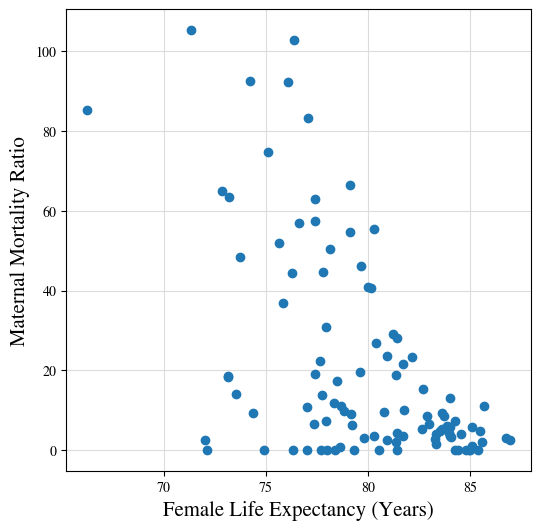

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(
    x=all_data["FemLifeExp"].values, 
    y=all_data["MMR"].values, zorder=10)
ax.grid(True, color='gainsboro')
ax.set_ylabel("Maternal Mortality Ratio", fontsize=lbfs)
ax.set_xlabel("Female Life Expectancy (Years)", fontsize=lbfs)
plt.show()

# Color-Coding and prettifying

In [31]:
# I would like to color-code the scatter based on the region of the world

In [32]:
len(set(all_data["Region"].values))  # we currently have this many countries

102

In [33]:
len(set(all_data["Region"].values).intersection(owid_countries))  # intersection with OWID gives a few less

92

In [34]:
inter_countries = set(all_data["Region"].values).intersection(owid_countries)

In [35]:
set(all_data["Region"].values).difference(inter_countries)

{'Brunei Darussalam',
 'China, Hong Kong SAR',
 'Iran (Islamic Republic of)',
 'Republic of Korea',
 'Republic of Moldova',
 'Russian Federation',
 'Réunion',
 'Türkiye',
 'United States of America',
 'Venezuela (Bolivarian Republic of)'}

In [36]:
# 'United States of America' -> 'United States'
# 'Venezuela (Bolivarian Republic of)' -> 'Venezuela'
# 'Türkiye' -> 'Turkey'
# 'Réunion' -> 'Reunion'
# 'Russian Federation' -> 'Russia'
# 'Republic of Moldova' -> 'Moldova'
# 'Republic of Korea' -> 'South Korea'
# 'Iran (Islamic Republic of)' -> 'Iran'
# 'China, Hong Kong SAR' -> 'China'
# 'Brunei Darussalam' -> 'Brunei'

In [37]:
all_data.loc[all_data["Region"] == 'United States of America', "Region"] = 'United States'
all_data.loc[all_data["Region"] == 'Venezuela (Bolivarian Republic of)', "Region"] = 'Venezuela'
all_data.loc[all_data["Region"] == 'Türkiye', "Region"] = 'Turkey'
all_data.loc[all_data["Region"] == 'Réunion', "Region"] = 'Reunion'

In [38]:
all_data.loc[all_data["Region"] == 'Russian Federation', "Region"] = 'Russia'
all_data.loc[all_data["Region"] == 'Republic of Moldova', "Region"] = 'Moldova'
all_data.loc[all_data["Region"] == 'Republic of Korea', "Region"] = 'South Korea'
all_data.loc[all_data["Region"] == 'Iran (Islamic Republic of)', "Region"] = 'Iran'
all_data.loc[all_data["Region"] == 'China, Hong Kong SAR', "Region"] = 'China'
all_data.loc[all_data["Region"] == 'Brunei Darussalam', "Region"] = 'Brunei'

In [39]:
# now the intersection should be full
len(set(all_data["Region"].values).intersection(owid_countries))

102

In [40]:
full_data = pd.merge(all_data, continents[["Entity", "Continent"]], left_on='Region', right_on='Entity')

In [41]:
# we need to assign numbers to each of these continents

In [42]:
continent_color_mapper = {
    'Europe': '#2775C2',
    'Oceania': '#FFD9CE', #'#D741A7', #'#CC3363', #'#9a5129',
    'Asia': '#899D78',
    'Africa': '#5B3000',#'#a2559c',
    'North America': '#DF2935', #'#e56e5a',
    'South America': '#F49F0A' #'#883039'
    
}

In [43]:
full_data["ContinentNum"] = full_data["Continent"].map(continent_color_mapper)

In [44]:
unique_continents = list(continents["Continent"].unique())

In [45]:
unique_continents = [c for c in unique_continents if c != "Antarctica"]

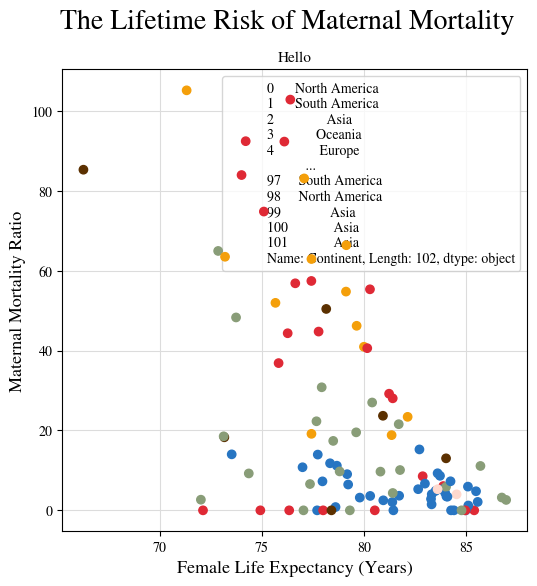

In [46]:
lbfs = 13
fig, ax = plt.subplots(figsize=(6,6))
sc = ax.scatter(
    x=full_data["FemLifeExp"].values, 
    y=full_data["MMR"].values, zorder=10,
    c=full_data["ContinentNum"],
    label=full_data["Continent"])
ax.grid(True, color='gainsboro')
ax.set_ylabel("Maternal Mortality Ratio", fontsize=lbfs)
ax.set_xlabel("Female Life Expectancy (Years)", fontsize=lbfs)
ax.set_title("Hello", fontsize=11)
ax.legend()
fig.suptitle("The Lifetime Risk of Maternal Mortality", fontsize=20)
plt.show()

In [47]:
# south african coordinates
x_southafrica = float(full_data[full_data["Region"] == "South Africa"]["FemLifeExp"].values[0])
y_southafrica = float(full_data[full_data["Region"] == "South Africa"]["MMR"].values[0])

x_guyana = float(full_data[full_data["Region"] == "Guyana"]["FemLifeExp"].values[0])
y_guyana = float(full_data[full_data["Region"] == "Guyana"]["MMR"].values[0])

x_china = float(full_data[full_data["Region"] == "China"]["FemLifeExp"].values[0])
y_china = float(full_data[full_data["Region"] == "China"]["MMR"].values[0])

x_usa = float(full_data[full_data["Region"] == "United States"]["FemLifeExp"].values[0])
y_usa = float(full_data[full_data["Region"] == "United States"]["MMR"].values[0])

x_spain = float(full_data[full_data["Region"] == "Spain"]["FemLifeExp"].values[0])
y_spain = float(full_data[full_data["Region"] == "Spain"]["MMR"].values[0])

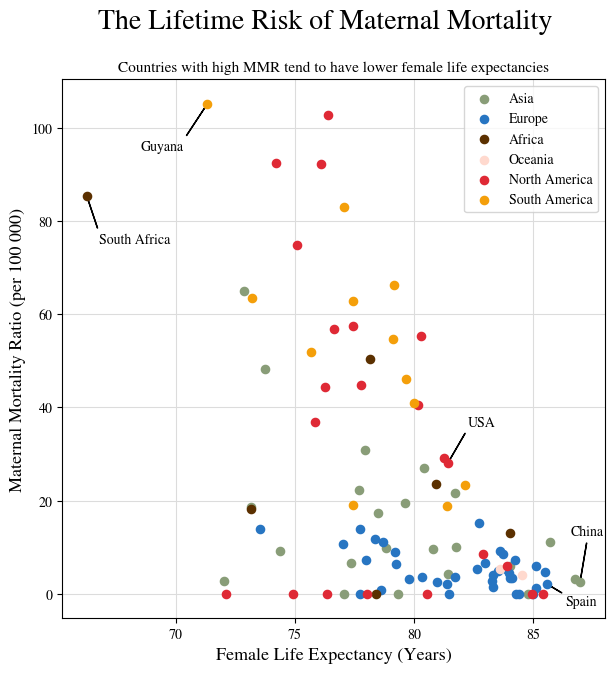

In [49]:
lbfs = 13
fig, ax = plt.subplots(figsize=(7,7))
for continent in unique_continents:
    ax.scatter(
        x=full_data[full_data["Continent"] == continent]["FemLifeExp"],
        y=full_data[full_data["Continent"] == continent]["MMR"],
        zorder=10,
        color=continent_color_mapper[continent],
        label=continent,
        s=35)
# annotate South Africa
ax.annotate('South Africa', xy=(x_southafrica, y_southafrica), xytext=(x_southafrica+3.5, y_southafrica-10),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=1, headlength=0.1),
            horizontalalignment='right')
# Annotate Guyana
ax.annotate('Guyana', xy=(x_guyana, y_guyana), xytext=(x_guyana-1, y_guyana-10),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=1, headlength=0.1),
            horizontalalignment='right')
# Annotate China
ax.annotate('China', xy=(x_china, y_china), xytext=(x_china+1, y_china+10),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=1, headlength=0.1),
            horizontalalignment='right')
# Annotate USA
ax.annotate('USA', xy=(x_usa, y_usa), xytext=(x_usa+2, y_usa+8),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=1, headlength=0.1),
            horizontalalignment='right')
# Annotate Spain
ax.annotate('Spain', xy=(x_spain, y_spain), xytext=(x_spain+2.1, y_spain-4.6),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=1, headlength=0.1),
            horizontalalignment='right')
ax.grid(True, color='gainsboro')
ax.set_ylabel("Maternal Mortality Ratio (per 100 000)", fontsize=lbfs)
ax.set_xlabel("Female Life Expectancy (Years)", fontsize=lbfs)
ax.set_title("Countries with high MMR tend to have lower female life expectancies", fontsize=11)
ax.legend()
fig.suptitle("The Lifetime Risk of Maternal Mortality", fontsize=20)
plt.savefig("mmr_vs_life_expectancy.png", dpi=1000)
plt.show()

In [272]:
full_data[full_data["FemLifeExp"] > 81].query("Continent == 'Africa'")

,Region,Number,Births,FemLifeExp,MMR,Entity,Continent,ContinentNum
72,Reunion,2.0,15356.0,84.027,13.024225,Reunion,Africa,#a2559c


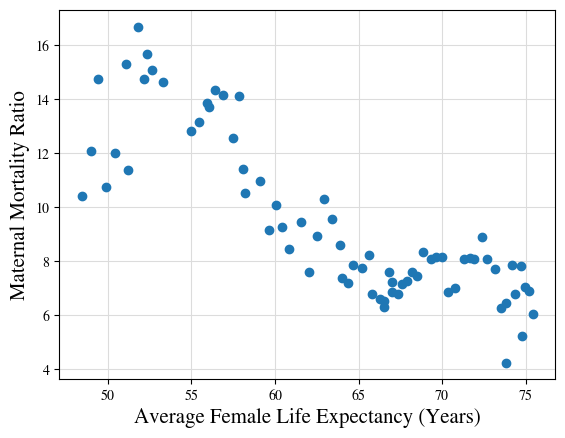

In [151]:
fig, ax = plt.subplots()
ax.grid(True, color='gainsboro')
ax.scatter(avg_female_life_exp_by_year, mmr_by_year, zorder=10)
ax.set_ylabel("Maternal Mortality Ratio", fontsize=lbfs)
ax.set_xlabel("Average Female Life Expectancy (Years)", fontsize=lbfs)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.grid(True, color='gainsboro')
mmr_by_year.plot()
ax.set_ylabel("Maternal Mortality Ratio", fontsize=lbfs)
ax.set_xlabel("Average Female Life Expectancy (Years)", fontsize=lbfs)
plt.show()

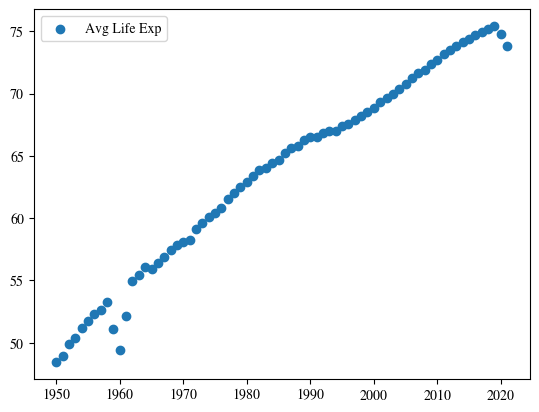

In [175]:
fig, ax = plt.subplots()
# ax.scatter(mmr_by_year.index, mmr_by_year, label='MMR')
ax.scatter(avg_female_life_exp_by_year.index, avg_female_life_exp_by_year, label='Avg Life Exp')
ax.legend()
plt.show()

In [168]:
mmr_by_year

Year
1950.0    10.419918
1951.0    12.073863
1952.0    10.754386
1953.0    11.997232
1954.0    11.395338
            ...    
2017.0     7.065425
2018.0     6.905456
2019.0     6.068084
2020.0     5.233378
2021.0     4.256028
Length: 72, dtype: object

In [71]:
mmr_by_year.dropna()

Year
1953.0    0.000332
1954.0    0.000368
1955.0    0.000566
1956.0    0.000515
1957.0    0.000498
            ...   
2017.0    0.000507
2018.0     0.00051
2019.0    0.000485
2020.0    0.000591
2021.0    0.000269
Length: 69, dtype: object

In [30]:
mortality["Country Name"].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Cabo Verde', 'Canada', 'Chile', 'Colombia',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France',
       'French Guiana', 'Georgia', 'Germany', 'Greece', 'Grenada',
       'Guadeloupe', 'Guatemala', 'Guyana', 'China, Hong Kong SAR',
       'Hungary', 'Iceland', 'Iran (Islamic Republic of)', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan',
       'Republic of Korea', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lithuania',
       'Luxembourg', 'Maldives', 'Malta', 'Martinique', 'Mauritius',
       'Mayotte', 'Mexico', 'Republic of Moldova', 'Mongolia',
       'Monten

In [31]:
mortality = pd.read_csv(
    "data/WHOMortalityDatabase_Map_Maternal conditions_28th March 2024 17_52.csv", skiprows=6, index_col=False
)

In [27]:
n_deaths_mat_deaths_by_year = mortality.groupby("Year")["Number"].sum()

UndefinedVariableError: local variable 'years_with_80pc' is not defined